In [1]:
using Revise

In [2]:
# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations
using Land
using Land.PhysCon
using Land.WaterVapor
using Land.Leaf
#using IncGammaBeta
output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

┌ Info: Precompiling Land [27e3c115-2cb8-4114-b7a5-cd9f011f9dcc]
└ @ Base loading.jl:1260


Reading Optical Parameters from 400.0 to 2380.0 length: 115


"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/Land/test/../output"

In [197]:
# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();

# initialize some reasonable values
f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; f.H=0;f.LE=0; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=100e-3; l.RWC=80/100;l.psi_l=-1.1e6;l.psi_l50 = -3e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;
met.stab_type_stable = 2;
l.gstyp = 3;

In [212]:
# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 800; # W/m2 amplitude
Tmean   = 273.15+10;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end

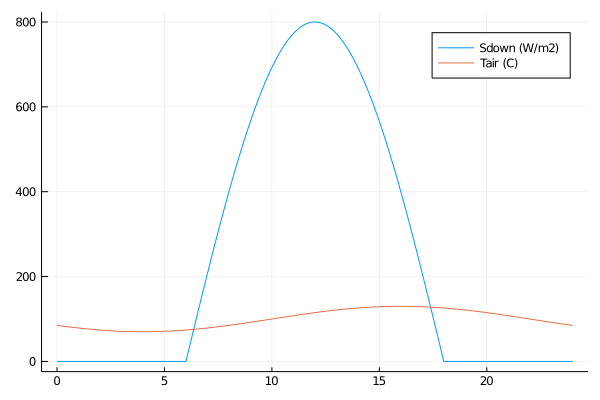

In [213]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [214]:
psi_s      = -1e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    f::fluxes;
    psi_s;
end

In [215]:
# small time stepping
dt     = 0.1*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Cc_t   = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
GPP_t  = zeros(size(Sdown_t));
GPP_diffusion_t  = zeros(size(Sdown_t));
LUE_t  = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
Sap_t  = zeros(size(Sdown_t));
rs_t   = zeros(size(Sdown_t));
ra_t   = zeros(size(Sdown_t));

function f_ode!(du,u,p,t) # p are parameters
    du .= LeafEnergyWaterBalance(u[1], u[2], u[3], p.met, p.l, p.f, p.psi_s);
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    # initial conditions
    met.T_air  = Tair_t[1];
    l.T        = met.T_air;
    l.psi_l    = psi_s;
    l.Cc       = 0.6*met.Ca;
    #println("Tair1=",met.T_air," Tleaf1=",l.T," psi_leaf1=",l.psi_l)
        
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        f.APAR     = met.PAR;
        #println("Tair=",met.T_air," Tleaf=",l.T," psi_leaf=",l.psi_l)
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l;l.Cc];
            p    = parameters_ode(l,met,f,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            #du   = zeros(size(u));
            #f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            # Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
            
            
            du   = zeros(size(u));
            f_ode!(du,u,p,t);
            (l.T,l.psi_l,l.Cc) = du*dt+u;
            
#            u0   = [l.T;l.psi_l;l.Cc];
#            prob = ODEProblem(f_ode!,u0,tspan,p);
#            sol  = solve(prob);            
#            # save values
#            met = p.met;
#            f   = p.f;
#            l   = p.l;
#            (l.T,l.psi_l,l.Cc) = sol[1:3,end];
            
            #println("Cc_out=",l.Cc)
            Rn_t[i] = p.f.Rn; H_t[i] = p.f.H; LE_t[i] = p.f.LE; Sap_t[i] = p.f.Sap*Lv(l.T);
            rs_t[i] = 1.0/(p.l.gs/p.f.g_m_s_to_mol_m2_s); 
            ra_t[i] = p.f.ra; 
            GPP_t[i]= p.f.An_biochemistry; 
            GPP_diffusion_t[i]= p.f.An_diffusion; 
            LUE_t[i]= p.f.An_biochemistry/f.APAR; 
            
            #T_old   = l.T;
            #(l.T,l.psi_l) = du*dt+u;
            T_t[i]    = l.T ; #  = T_old; 
            psil_t[i] = l.psi_l;
            Cc_t[i]   = l.Cc;
            
            if(abs(H_t[i])>500)
                println("index ($i) ($j)")
            end
            
            
#             (dumb,l.psi_l) = du*dt+u;
#             T_t[i]  = dumb ; #  = T_old; 

            
        end
    end
   
end


psi_l=-1.0e6 psi_s=-1.0e6 (Pa), Sap=-455691.9327344686 W/m^2, kx=1.4039369e-5, rho.g.h=9806.650390625 dH2O_dt=-768967.9432518842 μ_l=0.00135837916519432 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-5.6138075e6 psi_s=-1.0e6 (Pa), Sap=2725.990268629374 W/m^2, kx=1.7595271e-10, rho.g.h=9806.650390625 dH2O_dt=4578.572768271702 μ_l=0.0013802558003880119 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-5.586336e6 psi_s=-1.0e6 (Pa), Sap=2766.5771546039196 W/m^2, kx=1.7698025e-10, rho.g.h=9806.650390625 dH2O_dt=4649.443372571405 μ_l=0.001400303153332869 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-5.5584395e6 psi_s=-1.0e6 (Pa), Sap=2806.0467939903438 W/m^2, kx=1.780345e-10, rho.g.h=9806.650390625 dH2O_dt=4716.592044621587 μ_l=0.001419820461579698 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-5.53014e6 psi_s=-1.0e6 (Pa), Sap=2844.3530851781875 W/m^2, kx=1.7911522e-10, rho.g.h=9806.650390625 dH2O_dt=4780.5642272735695 μ_l=0.0014387875100978914 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-5.50145

psi_l=-3.9888102e6 psi_s=-1.0e6 (Pa), Sap=3335.020544713167 W/m^2, kx=2.5562336e-10, rho.g.h=9806.650390625 dH2O_dt=5573.626195222969 μ_l=0.0017801896440228114 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-3.9553685e6 psi_s=-1.0e6 (Pa), Sap=3325.7062754790354 W/m^2, kx=2.5761007e-10, rho.g.h=9806.650390625 dH2O_dt=5557.918873169219 μ_l=0.0017814811209447752 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-3.922021e6 psi_s=-1.0e6 (Pa), Sap=3315.763650689337 W/m^2, kx=2.5959898e-10, rho.g.h=9806.650390625 dH2O_dt=5541.17160819558 μ_l=0.0017826878162586653 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-3.888774e6 psi_s=-1.0e6 (Pa), Sap=3305.2001969363723 W/m^2, kx=2.61589e-10, rho.g.h=9806.650390625 dH2O_dt=5523.3960903899015 μ_l=0.0017838158567232954 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-3.8556335e6 psi_s=-1.0e6 (Pa), Sap=3294.023999816749 W/m^2, kx=2.6357913e-10, rho.g.h=9806.650390625 dH2O_dt=5504.605471227183 μ_l=0.001784870683310115 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-3

psi_l=-2.5104725e6 psi_s=-1.0e6 (Pa), Sap=2270.119883485403 W/m^2, kx=3.413235e-10, rho.g.h=9806.650390625 dH2O_dt=3792.3784257567 μ_l=0.0018007916636726198 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-2.4877182e6 psi_s=-1.0e6 (Pa), Sap=2243.168820547646 W/m^2, kx=3.4244582e-10, rho.g.h=9806.650390625 dH2O_dt=3747.3476143383127 μ_l=0.0018008839810589932 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-2.4652342e6 psi_s=-1.0e6 (Pa), Sap=2216.2399738136323 W/m^2, kx=3.4354453e-10, rho.g.h=9806.650390625 dH2O_dt=3702.3545527878896 μ_l=0.0018009701989913386 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-2.44302e6 psi_s=-1.0e6 (Pa), Sap=2189.343121385825 W/m^2, kx=3.4461983e-10, rho.g.h=9806.650390625 dH2O_dt=3657.415558709189 μ_l=0.0018010485990492407 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-2.4210755e6 psi_s=-1.0e6 (Pa), Sap=2162.495254187447 W/m^2, kx=3.4567196e-10, rho.g.h=9806.650390625 dH2O_dt=3612.5588834833684 μ_l=0.0018011228534530082 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=

psi_l=-1.6668809e6 psi_s=-1.0e6 (Pa), Sap=1094.1424354263747 W/m^2, kx=3.7508482e-10, rho.g.h=9806.650390625 dH2O_dt=1827.7022904972755 μ_l=0.001803724310725393 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.6559146e6 psi_s=-1.0e6 (Pa), Sap=1076.8487629957206 W/m^2, kx=3.754111e-10, rho.g.h=9806.650390625 dH2O_dt=1798.8115628020896 μ_l=0.0018037746927744894 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.6451218e6 psi_s=-1.0e6 (Pa), Sap=1059.787310543644 W/m^2, kx=3.7572928e-10, rho.g.h=9806.650390625 dH2O_dt=1770.3089268014025 μ_l=0.001803822879896457 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.6344999e6 psi_s=-1.0e6 (Pa), Sap=1042.9569885425758 W/m^2, kx=3.7603964e-10, rho.g.h=9806.650390625 dH2O_dt=1742.192555919884 μ_l=0.001803868871935064 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.6240468e6 psi_s=-1.0e6 (Pa), Sap=1026.3545204634847 W/m^2, kx=3.7634246e-10, rho.g.h=9806.650390625 dH2O_dt=1714.456970350643 μ_l=0.0018039092280536292 μ_l(273.15+20.0)=0.0010176488244921045
ps

psi_l=-1.2574365e6 psi_s=-1.0e6 (Pa), Sap=424.2375452647622 W/m^2, kx=3.8532802e-10, rho.g.h=9806.650390625 dH2O_dt=708.5960580891352 μ_l=0.0018063170040902876 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.2531849e6 psi_s=-1.0e6 (Pa), Sap=417.0614741431832 W/m^2, kx=3.8541428e-10, rho.g.h=9806.650390625 dH2O_dt=696.6082624015428 μ_l=0.0018063774953754371 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.2490052e6 psi_s=-1.0e6 (Pa), Sap=410.00202386547784 W/m^2, kx=3.8549858e-10, rho.g.h=9806.650390625 dH2O_dt=684.8153651080856 μ_l=0.001806433828583358 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.2448964e6 psi_s=-1.0e6 (Pa), Sap=403.0578975579189 W/m^2, kx=3.855811e-10, rho.g.h=9806.650390625 dH2O_dt=673.2151741906576 μ_l=0.0018064879643113969 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.2408571e6 psi_s=-1.0e6 (Pa), Sap=396.22676408908814 W/m^2, kx=3.8566197e-10, rho.g.h=9806.650390625 dH2O_dt=661.8037929021172 μ_l=0.0018065364566855423 μ_l(273.15+20.0)=0.0010176488244921045
psi_l

psi_l=-1.111762e6 psi_s=-1.0e6 (Pa), Sap=176.14120269310368 W/m^2, kx=3.88061e-10, rho.g.h=9806.650390625 dH2O_dt=294.16071525371376 μ_l=0.0018086311388332938 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.109997e6 psi_s=-1.0e6 (Pa), Sap=173.1110983055997 W/m^2, kx=3.8809145e-10, rho.g.h=9806.650390625 dH2O_dt=289.09911380139863 μ_l=0.0018086875370790778 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.1082624e6 psi_s=-1.0e6 (Pa), Sap=170.13218584219476 W/m^2, kx=3.881214e-10, rho.g.h=9806.650390625 dH2O_dt=284.12305813343653 μ_l=0.0018087397721675736 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.1065576e6 psi_s=-1.0e6 (Pa), Sap=167.20359683044384 W/m^2, kx=3.8815068e-10, rho.g.h=9806.650390625 dH2O_dt=279.2310870709355 μ_l=0.0018087880820671083 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.1048822e6 psi_s=-1.0e6 (Pa), Sap=164.32451180516586 W/m^2, kx=3.8817927e-10, rho.g.h=9806.650390625 dH2O_dt=274.4218305828362 μ_l=0.0018088324664828756 μ_l(273.15+20.0)=0.0010176488244921045
psi

psi_l=-1.0515756e6 psi_s=-1.0e6 (Pa), Sap=72.44163983170257 W/m^2, kx=3.890615e-10, rho.g.h=9806.650390625 dH2O_dt=120.94251477558643 μ_l=0.0018109072773639587 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.05085e6 psi_s=-1.0e6 (Pa), Sap=71.18734906276089 W/m^2, kx=3.8907316e-10, rho.g.h=9806.650390625 dH2O_dt=118.84740345930219 μ_l=0.0018109578447881884 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0501369e6 psi_s=-1.0e6 (Pa), Sap=69.95445861489995 W/m^2, kx=3.8908457e-10, rho.g.h=9806.650390625 dH2O_dt=116.78804789491804 μ_l=0.0018110062095282409 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0494361e6 psi_s=-1.0e6 (Pa), Sap=68.74275006399202 W/m^2, kx=3.8909567e-10, rho.g.h=9806.650390625 dH2O_dt=114.76408276861132 μ_l=0.001811052371427386 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0487475e6 psi_s=-1.0e6 (Pa), Sap=67.55171334872162 W/m^2, kx=3.891067e-10, rho.g.h=9806.650390625 dH2O_dt=112.7746556545001 μ_l=0.001811092875946749 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-

psi_l=-1.0262912e6 psi_s=-1.0e6 (Pa), Sap=28.657302048213207 W/m^2, kx=3.8946119e-10, rho.g.h=9806.650390625 dH2O_dt=47.80909362829064 μ_l=0.0018132384227830369 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0260043e6 psi_s=-1.0e6 (Pa), Sap=28.159517440258114 W/m^2, kx=3.8946502e-10, rho.g.h=9806.650390625 dH2O_dt=46.97766258268811 μ_l=0.0018132789724566978 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.02572244e6 psi_s=-1.0e6 (Pa), Sap=27.670354166561385 W/m^2, kx=3.894688e-10, rho.g.h=9806.650390625 dH2O_dt=46.16063506235233 μ_l=0.001813317316482615 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0254455e6 psi_s=-1.0e6 (Pa), Sap=27.189812340352955 W/m^2, kx=3.8947406e-10, rho.g.h=9806.650390625 dH2O_dt=45.358011110836436 μ_l=0.0018133534547365602 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0251734e6 psi_s=-1.0e6 (Pa), Sap=26.717430404245256 W/m^2, kx=3.8947756e-10, rho.g.h=9806.650390625 dH2O_dt=44.56901821152709 μ_l=0.0018133858963092623 μ_l(273.15+20.0)=0.0010176488244921045


psi_l=-1.01653956e6 psi_s=-1.0e6 (Pa), Sap=11.723900249405522 W/m^2, kx=3.8961187e-10, rho.g.h=9806.650390625 dH2O_dt=19.526320940353468 μ_l=0.0018154288866732522 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0164224e6 psi_s=-1.0e6 (Pa), Sap=11.520135886102446 W/m^2, kx=3.8961323e-10, rho.g.h=9806.650390625 dH2O_dt=19.185996152377836 μ_l=0.0018154672727824566 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01630725e6 psi_s=-1.0e6 (Pa), Sap=11.319928434114583 W/m^2, kx=3.8961426e-10, rho.g.h=9806.650390625 dH2O_dt=18.85161354467594 μ_l=0.0018155034507981536 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0161941e6 psi_s=-1.0e6 (Pa), Sap=11.12320538290893 W/m^2, kx=3.8961648e-10, rho.g.h=9806.650390625 dH2O_dt=18.52305138296076 μ_l=0.001815535927896441 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.016083e6 psi_s=-1.0e6 (Pa), Sap=10.92991172231107 W/m^2, kx=3.8961762e-10, rho.g.h=9806.650390625 dH2O_dt=18.20022053173108 μ_l=0.001815566196617605 μ_l(273.15+20.0)=0.0010176488244921045
p

psi_l=-1.0128113e6 psi_s=-1.0e6 (Pa), Sap=5.238504496579966 W/m^2, kx=3.8966846e-10, rho.g.h=9806.650390625 dH2O_dt=8.694615965261612 μ_l=0.0018173666219073908 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0127591e6 psi_s=-1.0e6 (Pa), Sap=5.147665250204954 W/m^2, kx=3.8966885e-10, rho.g.h=9806.650390625 dH2O_dt=8.542900780580679 μ_l=0.0018174151450880904 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0127079e6 psi_s=-1.0e6 (Pa), Sap=5.058463841029684 W/m^2, kx=3.896704e-10, rho.g.h=9806.650390625 dH2O_dt=8.393921743345798 μ_l=0.0018174614585086575 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0126575e6 psi_s=-1.0e6 (Pa), Sap=4.970734680013252 W/m^2, kx=3.8966902e-10, rho.g.h=9806.650390625 dH2O_dt=8.24740201741447 μ_l=0.001817504067559817 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.012608e6 psi_s=-1.0e6 (Pa), Sap=4.88457275519312 W/m^2, kx=3.896717e-10, rho.g.h=9806.650390625 dH2O_dt=8.103500427447639 μ_l=0.001817544466483527 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.012

psi_l=-1.01104e6 psi_s=-1.0e6 (Pa), Sap=2.1530456540120686 W/m^2, kx=3.8969447e-10, rho.g.h=9806.650390625 dH2O_dt=3.541563930815016 μ_l=0.0018194963763811117 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01101875e6 psi_s=-1.0e6 (Pa), Sap=2.1160064324492596 W/m^2, kx=3.8969464e-10, rho.g.h=9806.650390625 dH2O_dt=3.479705168293279 μ_l=0.0018195427390010723 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0109979e6 psi_s=-1.0e6 (Pa), Sap=2.079622714010112 W/m^2, kx=3.8969658e-10, rho.g.h=9806.650390625 dH2O_dt=3.4189414608538238 μ_l=0.0018195834188805002 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0109774e6 psi_s=-1.0e6 (Pa), Sap=2.043882259167692 W/m^2, kx=3.8969686e-10, rho.g.h=9806.650390625 dH2O_dt=3.359252366821583 μ_l=0.001819623621632852 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01095725e6 psi_s=-1.0e6 (Pa), Sap=2.008781580245415 W/m^2, kx=3.896954e-10, rho.g.h=9806.650390625 dH2O_dt=3.3006319357448364 μ_l=0.0018196601154980966 μ_l(273.15+20.0)=0.0010176488244921045
psi

psi_l=-1.0103277e6 psi_s=-1.0e6 (Pa), Sap=0.9106528182928791 W/m^2, kx=3.8970646e-10, rho.g.h=9806.650390625 dH2O_dt=1.4667033097468598 μ_l=0.0018215371169602993 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0103189e6 psi_s=-1.0e6 (Pa), Sap=0.8952686587489428 W/m^2, kx=3.897045e-10, rho.g.h=9806.650390625 dH2O_dt=1.4410110232272364 μ_l=0.0018215815515169858 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01031025e6 psi_s=-1.0e6 (Pa), Sap=0.8802197858126879 W/m^2, kx=3.8970657e-10, rho.g.h=9806.650390625 dH2O_dt=1.4158787756558762 μ_l=0.0018216240107343292 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01030175e6 psi_s=-1.0e6 (Pa), Sap=0.8653816228458362 W/m^2, kx=3.8970643e-10, rho.g.h=9806.650390625 dH2O_dt=1.3910985381417442 μ_l=0.001821662518097769 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0102934e6 psi_s=-1.0e6 (Pa), Sap=0.8507599414108048 W/m^2, kx=3.8970652e-10, rho.g.h=9806.650390625 dH2O_dt=1.3666800115768216 μ_l=0.0018216970733724745 μ_l(273.15+20.0)=0.001017648824492

psi_l=-1.0100686e6 psi_s=-1.0e6 (Pa), Sap=0.45830332632458654 W/m^2, kx=3.8970818e-10, rho.g.h=9806.650390625 dH2O_dt=0.7112722978291753 μ_l=0.001823190366871968 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0100644e6 psi_s=-1.0e6 (Pa), Sap=0.4508807035781733 W/m^2, kx=3.8970993e-10, rho.g.h=9806.650390625 dH2O_dt=0.6988762445668574 μ_l=0.0018232308828665755 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0100602e6 psi_s=-1.0e6 (Pa), Sap=0.4435647208516699 W/m^2, kx=3.8971054e-10, rho.g.h=9806.650390625 dH2O_dt=0.6866583849092911 μ_l=0.0018232674436600268 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.01005606e6 psi_s=-1.0e6 (Pa), Sap=0.43635596352237954 W/m^2, kx=3.8971e-10, rho.g.h=9806.650390625 dH2O_dt=0.6746196719467631 μ_l=0.0018233020270793068 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.010052e6 psi_s=-1.0e6 (Pa), Sap=0.429254454316342 W/m^2, kx=3.897083e-10, rho.g.h=9806.650390625 dH2O_dt=0.6627601260780644 μ_l=0.0018233343938025455 μ_l(273.15+20.0)=0.0010176488244921045

psi_l=-1.00992394e6 psi_s=-1.0e6 (Pa), Sap=0.20542005897273885 W/m^2, kx=3.8971187e-10, rho.g.h=9806.650390625 dH2O_dt=0.28895409488366564 μ_l=0.0018251981070820148 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0099222e6 psi_s=-1.0e6 (Pa), Sap=0.2023587730133823 W/m^2, kx=3.8971093e-10, rho.g.h=9806.650390625 dH2O_dt=0.2838415090789598 μ_l=0.0018252347043719158 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0099205e6 psi_s=-1.0e6 (Pa), Sap=0.19940862286324484 W/m^2, kx=3.8971396e-10, rho.g.h=9806.650390625 dH2O_dt=0.2789145479568133 μ_l=0.0018252690829496858 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0099188e6 psi_s=-1.0e6 (Pa), Sap=0.19645613022664446 W/m^2, kx=3.8971312e-10, rho.g.h=9806.650390625 dH2O_dt=0.2739837526963433 μ_l=0.001825301482044311 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0099172e6 psi_s=-1.0e6 (Pa), Sap=0.19361351673162125 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.26923646681780766 μ_l=0.0018253319015569234 μ_l(273.15+20.0)=0.0010176488

psi_l=-1.0098659e6 psi_s=-1.0e6 (Pa), Sap=0.10384166385776386 W/m^2, kx=3.8971434e-10, rho.g.h=9806.650390625 dH2O_dt=0.11930938358605317 μ_l=0.001827124478456224 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098652e6 psi_s=-1.0e6 (Pa), Sap=0.10263797870855018 W/m^2, kx=3.8971296e-10, rho.g.h=9806.650390625 dH2O_dt=0.1172988267353142 μ_l=0.0018271608720252278 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098645e6 psi_s=-1.0e6 (Pa), Sap=0.10143403940216728 W/m^2, kx=3.8971154e-10, rho.g.h=9806.650390625 dH2O_dt=0.11528790169148 μ_l=0.0018271935417099676 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098638e6 psi_s=-1.0e6 (Pa), Sap=0.10023104789691861 W/m^2, kx=3.8971404e-10, rho.g.h=9806.650390625 dH2O_dt=0.11327858411601496 μ_l=0.001827225972471219 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098631e6 psi_s=-1.0e6 (Pa), Sap=0.09902712268996013 W/m^2, kx=3.8971393e-10, rho.g.h=9806.650390625 dH2O_dt=0.11126775443465664 μ_l=0.0018272544396242816 μ_l(273.15+20.0)=0.00101764882

psi_l=-1.00984194e6 psi_s=-1.0e6 (Pa), Sap=0.061936774890615616 W/m^2, kx=3.8971354e-10, rho.g.h=9806.650390625 dH2O_dt=0.049313362994326745 μ_l=0.0018290118573151561 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098416e6 psi_s=-1.0e6 (Pa), Sap=0.06138923372528136 W/m^2, kx=3.8971162e-10, rho.g.h=9806.650390625 dH2O_dt=0.04839850133899248 μ_l=0.0018290482857775616 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098413e6 psi_s=-1.0e6 (Pa), Sap=0.06084207963284937 W/m^2, kx=3.8971357e-10, rho.g.h=9806.650390625 dH2O_dt=0.04748430892103448 μ_l=0.0018290790027125554 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.009841e6 psi_s=-1.0e6 (Pa), Sap=0.060294286378501906 W/m^2, kx=3.8971162e-10, rho.g.h=9806.650390625 dH2O_dt=0.04656911412326361 μ_l=0.001829109480541732 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00984075e6 psi_s=-1.0e6 (Pa), Sap=0.05985694839022645 W/m^2, kx=3.8971504e-10, rho.g.h=9806.650390625 dH2O_dt=0.045838365192997235 μ_l=0.001829137974856601 μ_l(273.15+20.0)=0.00

psi_l=-1.00983144e6 psi_s=-1.0e6 (Pa), Sap=0.04355696026409979 W/m^2, kx=3.897116e-10, rho.g.h=9806.650390625 dH2O_dt=0.018599204393144386 μ_l=0.001831053336673231 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098313e6 psi_s=-1.0e6 (Pa), Sap=0.043338518143849335 W/m^2, kx=3.8971262e-10, rho.g.h=9806.650390625 dH2O_dt=0.018233702671979126 μ_l=0.0018310982261769899 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098312e6 psi_s=-1.0e6 (Pa), Sap=0.04312015745053361 W/m^2, kx=3.8971498e-10, rho.g.h=9806.650390625 dH2O_dt=0.017868338686755976 μ_l=0.0018311408909681794 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00983106e6 psi_s=-1.0e6 (Pa), Sap=0.042901112550504 W/m^2, kx=3.8971212e-10, rho.g.h=9806.650390625 dH2O_dt=0.017501914912252444 μ_l=0.0018311795845587493 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00983094e6 psi_s=-1.0e6 (Pa), Sap=0.04268258233991329 W/m^2, kx=3.8971446e-10, rho.g.h=9806.650390625 dH2O_dt=0.017136395101078207 μ_l=0.0018312162928084059 μ_l(273.15+20.0)=0.

psi_l=-1.00982775e6 psi_s=-1.0e6 (Pa), Sap=0.0371148145928213 W/m^2, kx=3.8971315e-10, rho.g.h=9806.650390625 dH2O_dt=0.007820308733813614 μ_l=0.001832844673845424 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098277e6 psi_s=-1.0e6 (Pa), Sap=0.037005670950714234 W/m^2, kx=3.897117e-10, rho.g.h=9806.650390625 dH2O_dt=0.007637334145873648 μ_l=0.0018328893641517024 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098276e6 psi_s=-1.0e6 (Pa), Sap=0.03689681411562664 W/m^2, kx=3.897142e-10, rho.g.h=9806.650390625 dH2O_dt=0.007454845404068346 μ_l=0.0018329300797882452 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982756e6 psi_s=-1.0e6 (Pa), Sap=0.036787537463783514 W/m^2, kx=3.8971276e-10, rho.g.h=9806.650390625 dH2O_dt=0.0072717309054796155 μ_l=0.0018329688083837832 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098275e6 psi_s=-1.0e6 (Pa), Sap=0.0366783339698072 W/m^2, kx=3.8971262e-10, rho.g.h=9806.650390625 dH2O_dt=0.007088745494726195 μ_l=0.0018330053099951714 μ_l(273.15+20.0)=0.

psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035500824708002976 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005103357151395987 μ_l=0.0018345944139630864 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035501681325380015 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104074160772782 μ_l=0.0018346371542628857 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03550249673453511 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104710097306283 μ_l=0.001834677905869972 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035503234177372375 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005105259732269005 μ_l=0.0018347146790064178 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.0355039638008036 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005105864889342461 μ_l=0.001834751212889402 μ_l(273.15+20.0)=0.

psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035544551216645896 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005147853648672371 μ_l=0.0018367779879179275 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03554520292853967 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005148366330211559 μ_l=0.0018368105763695035 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03554577666712511 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005148786486141208 μ_l=0.001836839181729371 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03554634258386595 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005149262159663924 μ_l=0.0018368675474338206 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035546836123422396 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005149629607948576 μ_l=0.0018368921698801598 μ_l(273.15+20.0)=0

psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03557744561850193 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005181866745539012 μ_l=0.0018384206767405773 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03557805838563362 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.005182358075211234 μ_l=0.0018384512987635697 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.035578632163958325 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051827969218664815 μ_l=0.0018384799277784743 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03557916135538383 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.00518319898291108 μ_l=0.0018385063235278121 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098268e6 psi_s=-1.0e6 (Pa), Sap=0.03557961371379032 W/m^2, kx=3.8971384e-10, rho.g.h=9806.650390625 dH2O_dt=0.00518354135515444 μ_l=0.0018385289727389953 μ_l(273.15+20.0)=0.

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03549878415103988 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005030468067579498 μ_l=0.0018400054283547666 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03549935790654751 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050308820707102965 μ_l=0.0018400340797752452 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035499923840783376 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005031357804071902 μ_l=0.001840062491340645 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03550041739450344 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005031719090724764 μ_l=0.001840087153354335 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03550090312673923 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005032111013634974 μ_l=0.0018401115754016887 μ_l(273.15+20.0)=0.

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03552962731523821 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005062336934275865 μ_l=0.0018415503114454035 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03553019888182554 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005062772127524365 μ_l=0.0018415789851382231 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03553073368455408 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005063183425502825 μ_l=0.0018416056625865976 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03553121944738835 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005063538062134435 μ_l=0.0018416301033433694 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03553170743695177 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005063964819609022 μ_l=0.0018416545444018084 μ_l(273.15+20.0)=0.

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.0355592746937717 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005093015771724737 μ_l=0.0018430352500074236 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03555984069772404 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005093448032457976 μ_l=0.0018430637046495742 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035560334314705136 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005093828028209219 μ_l=0.0018430884038282387 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035560822333712466 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094211280173057 μ_l=0.001843112862853076 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035561271360086764 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094566918395791 μ_l=0.0018431353239677292 μ_l(273.15+20.0)=0

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03558550300887526 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005120744852717249 μ_l=0.001844349007539515 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035586235075728306 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005121385053433494 μ_l=0.0018443857194861836 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03558688915353593 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005121858095155625 μ_l=0.0018444184330783653 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03558750201075326 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005122355769683733 μ_l=0.001844449147661693 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035588075873599065 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005122794737845775 μ_l=0.001844477863142532 μ_l(273.15+20.0)=0.0

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03561248491032379 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005148986947091387 μ_l=0.0018457003691542656 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.0356132226189024 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051494560382628635 μ_l=0.0018457373466973322 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03561391573064532 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005150025127972473 μ_l=0.0018457720834082734 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035614569846202024 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005150535510524796 μ_l=0.0018458048198016662 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03561514374178433 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051509558518551555 μ_l=0.001845833554823665 μ_l(273.15+20.0)=0

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03563931787000892 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005176687566404052 μ_l=0.0018470443989732851 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03564001884779765 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051771390098913446 μ_l=0.0018470793992172929 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03564067299894267 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005177661857839538 μ_l=0.0018471121571110344 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035641285925293004 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.00517814093508277 μ_l=0.001847142913259229 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.035641859853180344 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005178579957733303 μ_l=0.0018471716675681517 μ_l(273.15+20.0)=0

psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03566490300497348 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.00520317452727594 μ_l=0.0018483257821092253 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03566559841759907 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005203641691461466 μ_l=0.0018483605640219423 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03566621137595606 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005204127012969374 μ_l=0.0018483913394341832 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03566678756048396 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005204569776990583 μ_l=0.0018484201117387248 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.00982675e6 psi_s=-1.0e6 (Pa), Sap=0.03566732251799602 W/m^2, kx=3.897137e-10, rho.g.h=9806.650390625 dH2O_dt=0.005204974986493223 μ_l=0.0018484468808479585 μ_l(273.15+20.0)=0.0

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03558245344805497 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005046279577275365 μ_l=0.0018497617262920787 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03558282232599589 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050465452677818205 μ_l=0.001849780252628872 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.0355831522045752 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005048089032320752 μ_l=0.0018497967741558812 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03558380413496162 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005048514960758395 μ_l=0.0018498295767391197 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03558437806673925 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005048960255172741 μ_l=0.0018498583697723213 μ_l(273.15+20.0)=0.0

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03560570626264784 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005070297987796877 μ_l=0.0018509298594694232 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035606036157347726 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005070536069390041 μ_l=0.0018509463904844456 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03560635822374915 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005072035829873233 μ_l=0.0018509626806861646 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035606973410907086 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050724316606853516 μ_l=0.001850993496245632 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03560750614256805 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.00507283942022887 μ_l=0.001851020299829483 μ_l(273.15+20.0)=0.

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035627739764083885 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005093107114064693 μ_l=0.0018520367705582741 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03562806967429477 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005093376295651004 μ_l=0.0018520533107093213 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03562839398185958 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094792715746786 μ_l=0.0018520696099780297 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035628967967562666 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005095151012370504 μ_l=0.0018520984352960786 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035629500724102245 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005095583662113545 μ_l=0.0018521252536819505 μ_l(273.15+20.0)

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035655352728846804 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051220665365613515 μ_l=0.0018534239640388573 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03565576289558435 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005122376054159219 μ_l=0.0018534445330071088 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03565613183072992 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005122654228045406 μ_l=0.0018534630934803997 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03565649738877042 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005122951799658894 μ_l=0.0018534814130190226 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03565682731922466 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.00512321478055304 μ_l=0.0018534979650928244 μ_l(273.15+20.0)=0

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03567479250183446 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005142167858969136 μ_l=0.001854400500134125 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03567516145181439 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051424398282626385 μ_l=0.0018544190694686023 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03567549139540803 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005142677951674427 μ_l=0.0018544356292803832 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03567585696772319 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005143006620266912 μ_l=0.0018544539577726351 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03567614790507541 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005143198463813822 μ_l=0.0018544685081446745 μ_l(273.15+20.0)=0.

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03569264801476943 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005160726384370385 μ_l=0.0018552974109017671 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035693016978674816 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005161010799399128 μ_l=0.001855315988548984 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03569338816968848 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005161311364848778 μ_l=0.0018553345663681118 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03569375152838024 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005161592808755905 μ_l=0.0018553529031360822 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03569404247696521 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005161797096110399 μ_l=0.0018553674600132815 μ_l(273.15+20.0)=0.

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03571305018298428 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005181892999038219 μ_l=0.0018563223349679413 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035713415782985675 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005182103569092173 μ_l=0.001856340680829417 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03571374575349199 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005182403883918151 μ_l=0.001856357256499448 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03571407011753279 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.00518263284131857 μ_l=0.0018563735910191624 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.035714322069237435 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005182809508011837 μ_l=0.0018563861436063755 μ_l(273.15+20.0)=0.0

psi_l=-1.0098267e6 psi_s=-1.0e6 (Pa), Sap=0.03573923990923424 W/m^2, kx=3.8971226e-10, rho.g.h=9806.650390625 dH2O_dt=0.005208467756556857 μ_l=0.0018576378638803296 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03562819288462785 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005022805610083737 μ_l=0.00185764817000685 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035628564072406374 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005024368192689503 μ_l=0.001857666769441496 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03562893303356265 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005024161520235451 μ_l=0.001857685369048249 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03562929639071913 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050246419266775175 μ_l=0.0018577037274576016 μ_l(273.15+20.0)=0.00

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03564164590782651 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050369360570829205 μ_l=0.001858325995028076 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03564184540658519 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005036926245515574 μ_l=0.0018583360632837046 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03564217536908631 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005038364221084862 μ_l=0.0018583526554200517 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03564250533182464 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00503815479596996 μ_l=0.0018583692476928618 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03564282968990549 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050385889241310435 μ_l=0.001858385598690209 μ_l(273.15+20.0)=0.0

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035661115478961794 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005056881436970551 μ_l=0.00185930694002099 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035661398611862766 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005058079931766583 μ_l=0.001859321284039177 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03566168397190922 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005057939380144073 μ_l=0.0018593356281605467 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03566192809462287 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005058264796312928 μ_l=0.0018593479576998284 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0356621722174587 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005058416150836218 μ_l=0.0018593602873151283 μ_l(273.15+20.0)=0.00

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035671586284494974 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00506770873734872 μ_l=0.00185983458990658 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03567183041221399 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050687676955883535 μ_l=0.0018598469225179519 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03567207454005523 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005068633098748062 μ_l=0.0018598592552053726 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03567232089502474 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005068968450637502 μ_l=0.0018598715879688365 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035672523784786886 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005069051158858184 μ_l=0.0018598819055806537 μ_l(273.15+20.0)=0.

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03568091129990602 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005077362954348655 μ_l=0.0018603044902614414 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03568111642035775 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050782326462363945 μ_l=0.0018603148100993113 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035681321540897676 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050781201503268284 μ_l=0.001860325129990213 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035681526661525784 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005078399286297356 μ_l=0.0018603354499341592 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03568169054320194 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00507845436157927 μ_l=0.001860343754234259 μ_l(273.15+20.0)=0

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569069359204653 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050877528822834426 μ_l=0.001860797403027083 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569085970398379 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005087979517792637 μ_l=0.0018608057092330797 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569102358893552 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005088065678050146 μ_l=0.001860814015473218 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035691148461211845 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050881428498275386 μ_l=0.0018608203055665738 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0356913089662575 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050882981302436585 μ_l=0.0018608283703027057 μ_l(273.15+20.0)=0

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569720632286749 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0050943994847091395 μ_l=0.0018611254871760336 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569733119684268 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094576118557342 μ_l=0.0018611317782379969 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569748947673563 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094684170181038 μ_l=0.0018611398442397698 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03569757533756461 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00509472748934665 μ_l=0.0018611441188366342 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035697694604300494 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005094845200794236 μ_l=0.0018611501683725128 μ_l(273.15+20.0)=0

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570244934916121 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005099747721834129 μ_l=0.001861389654826971 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570256861701949 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005099915164132436 μ_l=0.0018613957051110941 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570265447885845 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005099946051744567 μ_l=0.0018613999802436316 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570277374676406 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00510006376405541 μ_l=0.001861406030559214 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570285960864391 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005100119516719127 μ_l=0.00186141030571335 μ_l(273.15+20.0)=0.00101

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035707118278646 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104488847746038 μ_l=0.001861624894223712 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570719853362513 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104610003374401 μ_l=0.001861628928222299 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035707276561536334 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051046590642984105 μ_l=0.0018616329622291648 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570732341034664 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104687179172169 μ_l=0.0018616352208497516 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570740143827792 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005104754888791886 μ_l=0.0018616392548693138 μ_l(273.15+20.0)=0.00

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035709652285276415 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00510704545472074 μ_l=0.0018617526098677 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570965789315178 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107048431100892 μ_l=0.0018617528514890548 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035709696907293594 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107076069840932 μ_l=0.0018617548686172972 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570973814852265 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107113641022406 μ_l=0.0018617568857475925 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570977716267006 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107147495978582 μ_l=0.0018617589028799677 μ_l(273.15+20.0)=0.00

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357109667196929 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005108306135717515 μ_l=0.0018618188503726413 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357109667196929 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005108287487106277 μ_l=0.0018618188503726413 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357109667196929 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005108293703310023 μ_l=0.0018618188503726413 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357109667196929 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005108293703310023 μ_l=0.0018618188503726413 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357109667196929 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005108293703310023 μ_l=0.0018618188503726413 μ_l(273.15+20.0)=0.00101

psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03571059769455125 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107772988007104 μ_l=0.0018618002124596562 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03571055645325509 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107735416766425 μ_l=0.0018617981952853354 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03571055645325509 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107760281591052 μ_l=0.0018617981952853354 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03571055645325509 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005107760281591052 μ_l=0.0018617981952853354 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035710517439047955 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.0051075772376286575 μ_l=0.0018617961781130872 μ_l(273.15+20.0)=

Excessive output truncated after 524301 bytes.


psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.0357087983487951 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005105823410022899 μ_l=0.0018617095258001352 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570879274095807 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005105845298530004 μ_l=0.0018617092841814661 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.03570875149980365 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00510580151118003 μ_l=0.0018617072670994643 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035708712485734415 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.00510581738601267 μ_l=0.0018617052500195224 μ_l(273.15+20.0)=0.0010176488244921045
psi_l=-1.0098266e6 psi_s=-1.0e6 (Pa), Sap=0.035708632230522126 W/m^2, kx=3.8971476e-10, rho.g.h=9806.650390625 dH2O_dt=0.005105466230205565 μ_l=0.001861701215865857 μ_l(273.15+20.0)=0.0

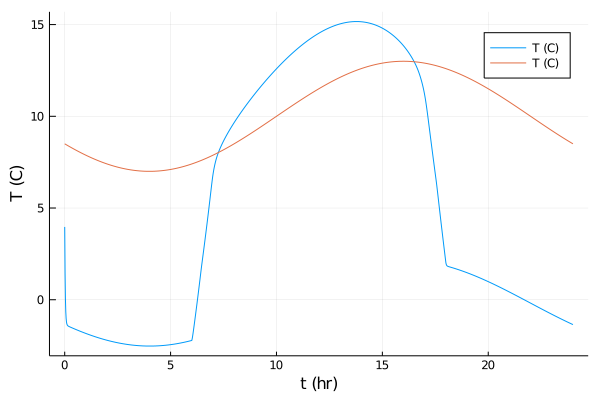

In [216]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)
plot!(t/3600, Tair_t-273.15*ones(size(Tair_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)

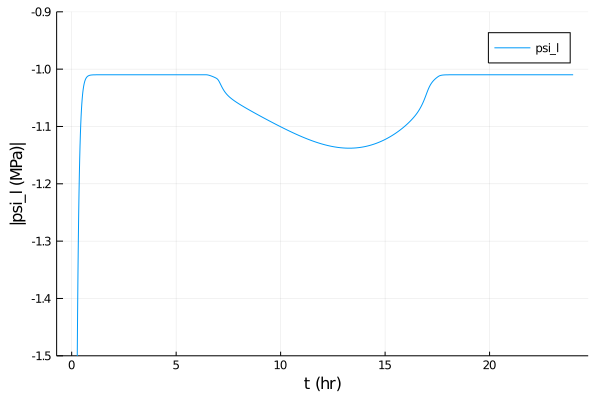

In [217]:
plot(t/3600,psil_t/1e6,xlabel = "t (hr)",ylabel = "|psi_l (MPa)|",label="psi_l",ylim=(-1.5,-0.9))

In [218]:
savefig(joinpath(output_dir, "T_psi_diurnal_t.png"))

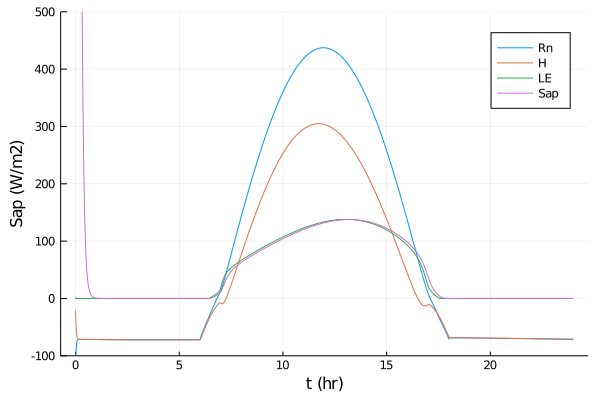

In [219]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn",ylim=(-100,500))
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H",ylim=(-100,500))
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE",ylim=(-100,500))
plot!(t/3600, Sap_t,xlabel = "t (hr)",ylabel = "Sap (W/m2)",label="Sap",ylim=(-100,500))

In [220]:
savefig(joinpath(output_dir, "Fluxes_diurnal_t.png"))

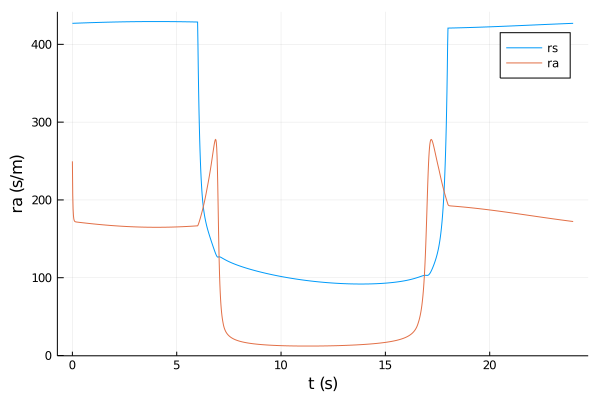

In [221]:
plot(t/3600,  rs_t,xlabel = "t (s)",ylabel = "rs (s/m)",label="rs")
plot!(t/3600, ra_t,xlabel  = "t (s)",ylabel = "ra (s/m)" ,label="ra")

In [222]:
savefig(joinpath(output_dir, "resistances_diurnal_t.png"))

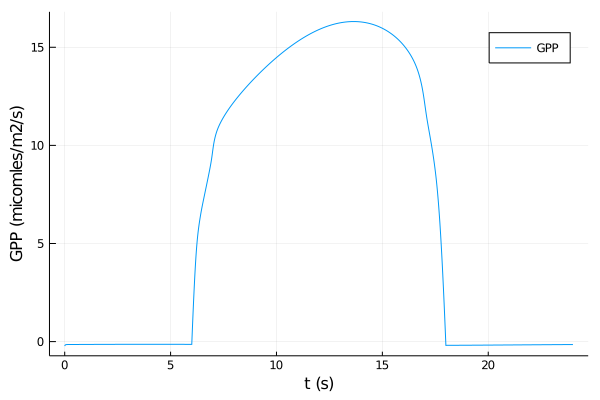

In [223]:
plot(t/3600, GPP_t,xlabel = "t (s)",ylabel = "GPP (micomles/m2/s)",label="GPP",ylim=0:100)

In [224]:
savefig(joinpath(output_dir, "GPP_diurnal_t.png"))

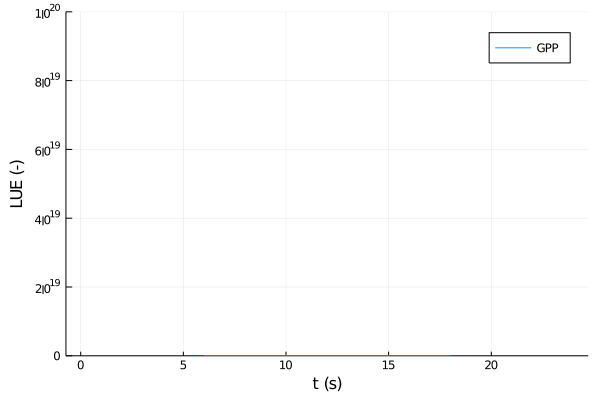

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [225]:
plot(t/3600, LUE_t,xlabel = "t (s)",ylabel = "LUE (-)",label="GPP",ylim=(0,1e20))

In [226]:
savefig(joinpath(output_dir, "LUE_diurnal_t.png"))

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un